In [1]:
# Import necessary libraries
from skimage.feature import ORB, match_descriptors
from skimage.io import imread
from skimage import io
from skimage.measure import ransac
from skimage.transform import ProjectiveTransform
from skimage.color import rgb2gray
from skimage.io import imsave, show
from skimage.color import gray2rgb
from skimage.exposure import rescale_intensity
from skimage.transform import warp
from skimage.transform import SimilarityTransform
import numpy as np

/home/ratan/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


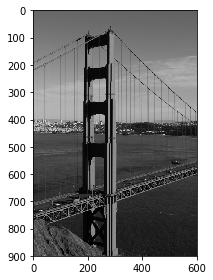

In [2]:
image0 = imread('images/goldengate1.png')
image0 = rgb2gray(image0)

# Display image
io.imshow(image0)
io.show()

/home/ratan/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


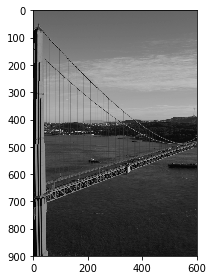

In [3]:
image1 = imread('images/goldengate2.png')
image1 = rgb2gray(image1)

# Display image
io.imshow(image1)
io.show()

In [4]:
# Define ORB features
orb = ORB(n_keypoints=1000, fast_threshold=0.05)

# Extract the features from both images
orb.detect_and_extract(image0)
keypoints1 = orb.keypoints
descriptors1 = orb.descriptors

orb.detect_and_extract(image1)
keypoints2 = orb.keypoints
descriptors2 = orb.descriptors

In [5]:
# Matches both images though their descriptors
matches12 = match_descriptors(descriptors1,
                              descriptors2,
                              cross_check=True)

/home/ratan/anaconda3/lib/python3.6/site-packages/skimage/feature/match.py:49: FutureWarning: Conversion of the second argument of issubdtype from `bool` to `np.generic` is deprecated. In future, it will be treated as `np.bool_ == np.dtype(bool).type`.
  if np.issubdtype(descriptors1.dtype, np.bool):


In [6]:
# Extract the matching features
src = keypoints2[matches12[:, 1]][:, ::-1]
dst = keypoints1[matches12[:, 0]][:, ::-1]

In [7]:
# Find the projection of source image over destination image
transform_model, inliers = \
    ransac((src, dst), ProjectiveTransform,
           min_samples=4, residual_threshold=2)

model_robust, inliners = \
    ransac((src, dst), ProjectiveTransform,
           min_samples=4, residual_threshold=2) 

r, c = image1.shape[:2]

In [8]:
# Define corners
corners = np.array([[0, 0],
                    [0, r],
                    [c, 0],
                    [c, r]])

# warp till the corners
warped_corners = transform_model(corners)

all_corners = np.vstack((warped_corners, corners))

corner_min = np.min(all_corners, axis=0)
corner_max = np.max(all_corners, axis=0)

In [9]:
# It saves differnce between the corners
output_shape = (corner_max - corner_min)
output_shape = np.ceil(output_shape[::-1])

In [10]:
offset = SimilarityTransform(translation=-corner_min)

# Warp the images according to offset
image0_warp = warp(image0, offset.inverse,
               output_shape=output_shape, cval=-1)

image1_warp = warp(image1, (model_robust + offset).inverse,
               output_shape=output_shape, cval=-1)

image0_mask = (image0_warp != -1)
image0_warp[~image0_mask] = 0
image0_alpha = np.dstack((gray2rgb(image0_warp), image0_mask))

image1_mask = (image1_warp != -1)
image1_warp[~image1_mask] = 0
image1_alpha = np.dstack((gray2rgb(image1_warp), image1_mask))

/home/ratan/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/ratan/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


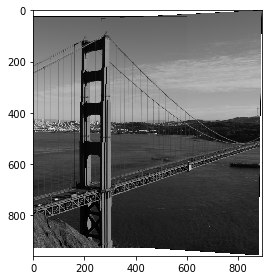

In [11]:
# Merge image
merged = (image0_alpha + image1_alpha)
alpha = merged[..., 3]
merged /= np.maximum(alpha, 1)[..., np.newaxis]

imsave('Saved_images/output.jpg', merged)
io.imshow(merged)
io.show()